In [1]:
import glob, os
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import rasterio.mask
import skopt
from scipy import optimize
from matplotlib import pyplot as plt
from rasterio import Affine
from rasterio.warp import reproject, Resampling

In [23]:
#Process the county sowing dataset
current_year = 2008
current_year_str = str(current_year)
os.chdir('/home/heisenberg/my_repo/Data')

df = pd.read_csv('maize.alldat.nolatlon.csv')
IL = (df['state']=='IL')&(df['YEAR']==current_year)
IL_county = df[IL]
col_list = ['FIPS','sday']
IL_county = IL_county[col_list]
IL_county = IL_county.groupby(['FIPS']).mean()
sow_date = list(IL_county['sday'])
del df

#Get all county FIPS in Illinois
county_FIPS = IL_county.index.values
county_FIPS = county_FIPS.tolist()
county_FIPS = list(map(str,county_FIPS))

In [15]:
#Get all counties in IL in the shape file
os.chdir('/home/heisenberg/my_repo/Data/County_Shape')
county_shape = gpd.read_file('CoUS_GCS12.shp')
county_shape = county_shape[county_shape['atlas_stco'].isin(county_FIPS)]
cols = ['atlas_stco','geometry']
county_shape = county_shape[cols]

In [16]:
#Read CDL data and change the CDL data to corn/non-corn
os.chdir('/home/heisenberg/my_repo/Data/CDL')
cdl_name = 'CDL_' + current_year_str + '.tif'
cdl = rasterio.open(cdl_name)
cdl_data = cdl.read(1)
cdl_data[cdl_data != 1] = 0

#Read state shape file
os.chdir('/home/heisenberg/my_repo/Data')
state = gpd.read_file('cb_2017_us_state_500k/')

In [17]:
def mask_by_county(county_shape, corn, i):
    img_clip, trans = rasterio.mask.mask(corn, [county_shape.iloc[i].geometry], crop=True)
    img_clip = img_clip.astype('float32')
    img_clip[img_clip == 0] = np.nan
    index = np.nanmean(img_clip)
    return (img_clip[0,:,:],index)

In [18]:
#Function that returns GCVI index for each county for each GCVI GeoTIFF
def calculate_GCVI(filename, state, cdl, cdl_data, county_shape):
    gcvi = rasterio.open(filename)
    state.crs = gcvi.crs

    img_clip, trans = rasterio.mask.mask(gcvi, [state.iloc[1].geometry], crop=True)
    img_clip = img_clip.astype('float32')
    img_clip[img_clip == 0] = np.nan
    #plt.imshow(img_clip[0,:,:],vmin=0, vmax=800, cmap='Spectral')

    #Project the CDL to GCVI size
    newarr = np.empty(shape=(img_clip.shape[0],
                             img_clip.shape[1],img_clip.shape[2]))
    reproject(
        cdl_data, newarr,
        src_transform = cdl.transform,
        dst_transform = gcvi.transform,
        src_crs = cdl.crs,
        dst_crs = gcvi.crs,
        resampling = Resampling.average)

    #Bigger than 0.5 means there is corn, while smaller than 0.5 means no corn
    is_corn = newarr >= 0.5
    corn_field = is_corn.astype(int)
    corn_field = corn_field.astype(np.float64)

    #Finally mask the corn/non-corn matrix with gcvi to get gcvi indexes
    gcvi_corn = np.multiply(img_clip, corn_field)
    #plt.imshow(gcvi_corn.squeeze())

    #Re-Write the projected GCVI to a new tif file
    os.chdir('/home/heisenberg/my_repo/Data/Output/')
    new_dataset = rasterio.open('filter1.tif', 'w', driver='GTiff',
                                height = corn_field.shape[1], width = corn_field.shape[2],
                                count = 1, dtype = corn_field.dtype,
                                crs = gcvi.crs,
                                transform = gcvi.transform)

    new_dataset.write(gcvi_corn.squeeze(),1)
    new_dataset.close()

    #Change the projection of shape file to cdl file.
    county_shape.crs = cdl.crs
    num_of_county = len(county_shape.index)


    #Read saved gcvi_corn raster file for masking
    test = rasterio.open('filter1.tif')
    #corn_by_county = {}
    index_by_county = {}

    for county in range(num_of_county):
        result = mask_by_county(county_shape,test,county)
        #corn_by_county[county] = result[0]
        index_by_county[county] = result[1]
    os.remove('filter1.tif')
    return index_by_county

In [19]:
#Iterate every tif file in a specific year's gcvi directory.
gcvi_directory = os.fsdecode('/home/heisenberg/my_repo/Data/GCVI/'+ current_year_str)
os.chdir(gcvi_directory)
index = 0
All_GCVI = {}

for infile in sorted(glob.glob(os.path.join('*.tif'))):
    os.chdir(gcvi_directory)
    All_GCVI[index] = calculate_GCVI(infile, state, cdl, cdl_data, county_shape)
    index += 1
    print(infile)
    print("image"+str(index)+" completed \n")
    
print("There are a total of " + str(len(All_GCVI)) + "gcvi images")

GCVI_filled_2008001.tif
image1 completed 

GCVI_filled_2008002.tif
image2 completed 

GCVI_filled_2008003.tif
image3 completed 

GCVI_filled_2008004.tif
image4 completed 

GCVI_filled_2008005.tif
image5 completed 

GCVI_filled_2008006.tif
image6 completed 

GCVI_filled_2008007.tif
image7 completed 

GCVI_filled_2008008.tif
image8 completed 

GCVI_filled_2008009.tif
image9 completed 

GCVI_filled_2008010.tif
image10 completed 

GCVI_filled_2008011.tif
image11 completed 

GCVI_filled_2008012.tif
image12 completed 

GCVI_filled_2008013.tif
image13 completed 

GCVI_filled_2008014.tif
image14 completed 

GCVI_filled_2008015.tif
image15 completed 

GCVI_filled_2008016.tif
image16 completed 

GCVI_filled_2008017.tif
image17 completed 

GCVI_filled_2008018.tif
image18 completed 

GCVI_filled_2008019.tif
image19 completed 

GCVI_filled_2008020.tif
image20 completed 

GCVI_filled_2008021.tif
image21 completed 

GCVI_filled_2008022.tif
image22 completed 

GCVI_filled_2008023.tif
image23 completed

GCVI_filled_2008186.tif
image186 completed 

GCVI_filled_2008187.tif
image187 completed 

GCVI_filled_2008188.tif
image188 completed 

GCVI_filled_2008189.tif
image189 completed 

GCVI_filled_2008190.tif
image190 completed 

GCVI_filled_2008191.tif
image191 completed 

GCVI_filled_2008192.tif
image192 completed 

GCVI_filled_2008193.tif
image193 completed 

GCVI_filled_2008194.tif
image194 completed 

GCVI_filled_2008195.tif
image195 completed 

GCVI_filled_2008196.tif
image196 completed 

GCVI_filled_2008197.tif
image197 completed 

GCVI_filled_2008198.tif
image198 completed 

GCVI_filled_2008199.tif
image199 completed 

GCVI_filled_2008200.tif
image200 completed 

GCVI_filled_2008201.tif
image201 completed 

GCVI_filled_2008202.tif
image202 completed 

GCVI_filled_2008203.tif
image203 completed 

GCVI_filled_2008204.tif
image204 completed 

GCVI_filled_2008205.tif
image205 completed 

GCVI_filled_2008206.tif
image206 completed 

GCVI_filled_2008207.tif
image207 completed 

GCVI_fille

TypeError: must be str, not int

In [20]:
#Concatenate dictionaries obtained from each image
from collections import defaultdict
dict_list = list(All_GCVI.values())
output = defaultdict(list)

for d in dict_list:
    for key, value in d.items():
        output[key].append(value)

#Save the data as csv file
os.chdir('/home/heisenberg/my_repo/Data/Output')
final = pd.DataFrame.from_dict(output)
final.to_csv('2008.csv',index=False)

In [33]:
#Read the saved data from csv file and optimize
os.chdir('/home/heisenberg/my_repo/Data/Output')
data = pd.read_csv('2008.csv', index_col=0)


In [30]:
data.iloc[:,0]

0
1.241597    1.461796
1.241670    1.462832
1.241810    1.461009
1.241963    1.460622
1.242113    1.462682
1.242261    1.464889
1.242437    1.467537
1.242630    1.470463
1.242758    1.473591
1.242921    1.479747
1.243209    1.484985
1.243271    1.477566
1.242963    1.462007
1.243088    1.441337
1.243357    1.424973
1.243387    1.409972
1.243619    1.397418
1.243259    1.390736
1.241047    1.386162
1.236471    1.378145
1.227503    1.370472
1.219992    1.367638
1.212446    1.362512
1.206828    1.352966
1.204349    1.347570
1.203991    1.346267
1.204108    1.342655
1.204536    1.341908
1.205523    1.345218
1.207106    1.348522
              ...   
1.336595    1.513484
1.331061    1.505454
1.326651    1.496227
1.324467    1.488658
1.322977    1.482998
1.321291    1.478255
1.319685    1.473931
1.318146    1.469898
1.316647    1.465886
1.315138    1.461355
1.313707    1.456662
1.312338    1.451885
1.310962    1.447037
1.309599    1.442175
1.308262    1.437319
1.306933    1.432476
1.305609   

In [34]:
#Start optimization process
def sigmoid(t):
    return 1 / (1 + np.exp(-t))


def Cost_a(x):
    def a_logistic(x,t):
        return Lmin_1 + dL_1 * sigmoid(-(x[0] - x[1] * t))
    time = np.arange(1,np.argmax(gcvi_values)+1)
    cost = 0
    for i in time:
        out = a_logistic(x,i)
        cost += (out - gcvi_values[i-1]) * (out - gcvi_values[i-1])
    return cost

def Cost_b(x):
    def b_logistic(x,t):
        return Lmin_2 + dL_2 * sigmoid(-(-x[0] + x[1]*(t - t12)))
    time = np.arange(np.argmax(gcvi_values)+1,length)
    cost = 0
    for i in time:
        out = b_logistic(x,i)
        cost += (out - gcvi_values[i-1]) * (out - gcvi_values[i-1])
    return cost


def Cost(x):
    def double_logistic(x,t):
        if t <= x[4]:
            return x[5] + x[7] * sigmoid(-(x[0] - x[1] * t))
        else:
            return x[6] + x[8] * sigmoid(-(-x[2] + x[3]*(t - x[4])))
    time = np.arange(1,length)
    cost = 0
    for i in time:
        out = double_logistic(x,i)
        cost += (out - gcvi_values[i-1]) * (out - gcvi_values[i-1])
    return cost

def double_logistic_plot(x,t):
    if t <= x[4]:
        return x[5] + x[7] * sigmoid(-(x[0] - x[1] * t))
    else:
        return x[6] + x[8] * sigmoid(-(-x[2] + x[3]*(t - x[4])))

    
num_of_county = len(county_FIPS)
predicted_by_county = []

for county in np.arange(num_of_county):
    gcvi_values = np.asarray(data.iloc[:,county])
    length = len(gcvi_values)
    print(length)
    
    Lmin_1 = gcvi_values[0]
    Lmin_2 = gcvi_values[-1]
    x = (0,0)
    dL_1 = gcvi_values.max() - Lmin_1
    y = (0,0)
    dL_2 = gcvi_values.max() - Lmin_2
    t12 = np.argmax(gcvi_values)


    res_1 = optimize.minimize(Cost_a, x, method='Nelder-Mead')
    res_2 = optimize.minimize(Cost_b, y, method='Nelder-Mead')

    z = np.zeros(9)
    z[4] = np.argmax(gcvi_values) + 1
    z[5] = Lmin_1
    z[6] = Lmin_2
    z[7] = gcvi_values.max() - Lmin_1
    z[8] = gcvi_values.max() - Lmin_2
    z[0] = res_1.x[0]
    z[1] = res_1.x[1]
    z[2] = res_2.x[0]
    z[3] = res_2.x[1]


    eq_cons = {'type': 'eq', 'fun' : lambda x: [x[7] * np.exp(x[2]) - x[8] * np.exp(x[1] * x[4] - x[0]) + x[7] - x[8]],'jac' : lambda x: np.array([x[8] * np.exp(x[1] * x[4] - x[0]), x[4] *-x[8] * np.exp(x[1] * x[4] - x[0]),x[7] * np.exp(x[2]), 0,x[1] *-x[8] * np.exp(x[1] * x[4] - x[0]),0,0,np.exp(x[2])+1,-1-np.exp(x[1] * x[4] - x[0])])}

    eq_cons_1 = {'type': 'eq', 'fun' : lambda x: x[7] + x[5] - x[8] - x[6],'jac' : lambda x: np.array([0,0,0,0,0,1,-1,1,-1])}

    res = optimize.minimize(Cost, z, method='SLSQP', jac = '2-point',constraints=(eq_cons,eq_cons_1),options={'maxiter':200})

    params = res.x
    days = np.arange(length)
    y = []
    for day in days:
        y.append(double_logistic_plot(params,day))

    y = np.asarray(y)
    predicted_by_county.append(np.argmax(y>1.2*y[0]))
    


366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366


IndexError: single positional indexer is out-of-bounds

In [32]:
num_of_county


92

ValueError: x and y must have same first dimension, but have shapes (91,) and (92,)

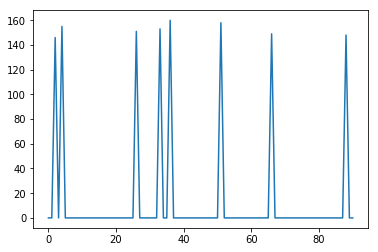

In [36]:
#Plot the predicted sow date to ground truth values for each year
counties = np.arange(num_of_county - 1)
predicted_by_county = np.asarray(predicted_by_county)
sow_date = np.asarray(sow_date)
pred, = plt.plot(counties, predicted_by_county, label='Predicted')
truth, = plt.plot(counties, sow_date, label='Ground Truth')
plt.legend(handles=[pred, truth])
plt.title('Predicted Sow Date vs. Actual Sow Date')
plt.xlabel('County')
plt.ylabel('Sow Day')